# Donald Trump Communication Analysis on Twitter

<b> Alexandra AMIENS, Julieva COHEN-SORS, Claire ZOUAOUI </b>

On January 20 the 45th President of the United States, Donald J. Trump, will leave the White House for President-elect Joe Biden to take over. In four years of an unprecedented presidency, Donald J. Trump mastered the use of social media. He overstepped traditional media like The New York Times, The Washington Post or CNN to rely only on Twitter where he used his own account and not the official account that the President of the U.S. is supposed to use.
Donald J. Trump has used Twitter  all along his term of office to express his opinion, to critize his oponents and to bring together his supporters around his beliefs.

A communication agency missioned our team of data analysts to analyze Donald Trump's communication on Twitter. They provided us with tweets from Donald Trump from 2009 to November 19,  2020.


The analysis hereunder  will disclose <b> how Donald Trump's Communication on Twitter reflects his rise to power until 2016 and his presidency until to 2020.</b>

We will use different Text Mining technics to retrieve what Trump's Tweets talk about and how Trump used Twitter in his communication strategy.

Our analysis will be split into:

 - A <b> Topic Modelling Analysis with the Latent Dirichlet Allocation algorithm </b> to study the main topics discussed in the Tweets 
 
 - A <b> Sentiment Analysis </b> to study the feelings associated to the tweets

 - An Analysis of the <b> Frequency of Tweets over time </b>

In [1]:
#First let's import pyspark and create a SparkContext
import pyspark
from pyspark import SparkContext

sc = pyspark.SparkContext(appName="Donald Trump Twitter Communication Analysis")

##  <span style="color:DodgerBlue"> 1- Topic Modelling using Latent Dirichlet allocation </span>


Latent Dirichlet Allocation (LDA) is one of the most common algorithms for unsupervised topic modeling.

The main idea behing the LDA algorithm is to map the tweets over a defined number of topics. Each topic is a set of keywords that are found in the documents. The LDA assesses for each word a probability to fall within each topic and then connects the topics to the documents based on what topics each document touches upon.

Here we'll use the LDA algorithm will allow us to identify the top 4 topics emerging from Donald Trump's communication.


In [2]:
# Initialize Parameters
from collections import defaultdict
import re
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.sql import SQLContext
sql_context = SQLContext(sc)

num_of_stop_words = 150      # Number of stopwords to remove, here we'll remove the 50 most common words
num_topics = 4               # Number of topics
num_words_per_topic = 10    # Number of words for each topic
max_iterations = 15

In [3]:
# Load Data
data = sc.textFile('trump_tweets.txt')

# Strip Each Tweet And Convert To Lower Case
# Split Each Document Into Words
# Keep Only Alphabetical Characters
# Keep Words Of At Least 3 Letters
tokens = data \
    .map(lambda tweet: tweet.strip().lower()) \
    .map(lambda tweet: re.split("[\s;,#]", tweet)) \
    .map(lambda word: [x for x in word if x.isalpha()]) \
    .map(lambda word: [x for x in word if len(x) > 3] )

In [4]:
# Convert the 'tokens' RDD Into A List Of Words
# Map Each Word To A Tuple Containing The Word And A Count Of 1 For That Word
# Sum The Counts For Each Word
# Sort By Decreasing Order With Highest Counts First

termCounts = tokens \
    .flatMap(lambda tweet: tweet) \
    .map(lambda word: (word, 1)) \
    .reduceByKey( lambda x,y: x + y) \
    .map(lambda tuple: (tuple[1], tuple[0])) \
    .sortByKey(False)
termCounts.take(10)

[(7969, 'will'),
 (7182, 'that'),
 (6676, 'great'),
 (6355, 'with'),
 (5665, 'have'),
 (4914, 'this'),
 (4809, 'trump'),
 (4421, 'they'),
 (3566, 'president'),
 (3424, 'thank')]

In [5]:
# Set A Threshold To Remove The Stopwords (identified here as the words that appear too often)
threshold_value = termCounts.take(num_of_stop_words)[num_of_stop_words - 1][0]

# Keep only keep words with a count less than the threshold (323)
vocabulary = termCounts \
    .filter(lambda x : x[0] < threshold_value) \
    .map(lambda x: x[1]) \
    .zipWithIndex() \
    .collectAsMap()

# Set Index Value To Each Word
inv_voc = {value: key for (key, value) in vocabulary.items()}

In [6]:
# Convert The Tweet Into A Vector Of Word Counts
def tweet_vector(tweet):
    id = tweet[1]
    counts = defaultdict(int)
    for token in tweet[0]:
        if token in vocabulary:
            token_id = vocabulary[token]
            counts[token_id] += 1
    counts = sorted(counts.items())
    keys = [x[0] for x in counts]
    values = [x[1] for x in counts]
    return (id, Vectors.sparse(len(vocabulary), keys, values))

In [7]:
# Process Tweets Into Vectors Of Words Using The 'tweet_vector' Function
tweets_docs = tokens.zipWithIndex().map(tweet_vector).map(list)

In [8]:
# Output Results Into A Text File
with open("topics.txt", 'w') as f:
    lda_model = LDA.train(tweets_docs, k=num_topics, maxIterations=max_iterations)
    topic_indices = lda_model.describeTopics(maxTermsPerTopic=num_words_per_topic)
        
    # Print topics with top-weighted 10 terms for each topic and their correlation to the topic
    for i in range(len(topic_indices)):
        f.write("Topic #{0}\n".format(i + 1))
        for j in range(len(topic_indices[i][0])):
            f.write("{0} {1}\n".format(inv_voc[topic_indices[i][0][j]], "{:.4f}".format(topic_indices[i][1][j])))
    f.write("{0} topics distributed over {1} unique words\n".format(num_topics, len(vocabulary)))

In [9]:
# Show Results
topics = sc.textFile("topics.txt")
topics.take(45)

['Topic #1',
 'those 0.0018',
 'while 0.0017',
 'business 0.0017',
 'north 0.0017',
 'amazing 0.0016',
 'senate 0.0016',
 'needs 0.0016',
 'americans 0.0016',
 'coming 0.0016',
 'york 0.0016',
 'Topic #2',
 'russia 0.0017',
 'north 0.0017',
 'those 0.0017',
 'true 0.0017',
 'business 0.0017',
 'making 0.0016',
 'senate 0.0016',
 'amazing 0.0016',
 'while 0.0016',
 'such 0.0016',
 'Topic #3',
 'while 0.0018',
 'needs 0.0017',
 'golf 0.0017',
 'business 0.0017',
 'wonderful 0.0017',
 'since 0.0017',
 'amazing 0.0017',
 'senate 0.0016',
 'crime 0.0016',
 'making 0.0016',
 'Topic #4',
 'while 0.0018',
 'golf 0.0018',
 'such 0.0017',
 'those 0.0017',
 'north 0.0017',
 'everyone 0.0017',
 'wonderful 0.0017',
 'senate 0.0017',
 'business 0.0017',
 'needs 0.0016',
 '4 topics distributed over 20481 unique words']

## <span style="color:MidnightBlue"> Insights from the Tweets </span>
 The topics overlap and some words are in common in several topics.


- Topic 1 revolves around making business and the senate and history. Prior to becoming President, Donald Trump was a real estate mogul and he had his own way of making business, often described as tough. It was foreseeable that business is emerging as an important topic from the Tweets.</span>

- Topic 2 revolves around golf, russia, 'maga' Trump's slogan in 2016 standing for 'Make America Great Again'. The word 'golf' emerges here because Trump owns several golf complex in the US, the most famous one is located in Palm Beach, Florida. All along his presidency, Trump has occasionally stayed to spend time with his family. Russia is an important word since in his presidency, Trump was accused of having Russia interfere in the US elections.

- Topic 3 revolves around business, russia, senate. We can see that this topic overlaps with topic 1 and 2. 

- Topic 4 is made up of 'senate', 'those', 'such', 'since'. The US Senate played an important role in Donald Trump's term because the President used his veto 9 times to block some laws to be voted by the Congress (Senate + Chamber of Representatives).

##  <span style="color:DodgerBlue"> 2 - Sentiment Analysis from Donald Trump Tweets </span>

The Sentiment Analysis will cover:

 - The 50 most important opinions words (25 positives and 25 negatives) used for each tweet

 - The 50 most important neutral (or contextual) words used for each tweet

 - A global sentiment score for each tweet from positives and negatives opinions words count 

###  <span style="color:Teal"> Step 1: Extracting Tweets words </span>

In [10]:
rdd_tweets = sc.textFile('trump_tweets.txt')

In [11]:
# Create Function To Split Lines into Individual Words By Using Multiple Separators
import re
def split_with_multiple_separator(string_value):
    return re.split('#|,| |\[|\]', string_value.strip())

# Example With The First Tweet
split_with_multiple_separator(rdd_tweets.take(5)[0])

['Republicans',
 'and',
 'Democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems.;02/08/2011',
 '18:07:48']

In [12]:
#Create Function To Remove Dates And Numbers
def remove_non_alpha_characters(string_value):
    return re.sub("[^a-zA-Z$]+", '', string_value)

In [13]:
# Compute An RDD With Individual Words From The 'rdd_tweets' By Using The 'split_with_multiple_separator' Function
# Convert To Lowercase
# Remove URLS
# Keep Only Words By Using The 'remove_non_alpha_characters' Function
# Map To Count The Number Of Letters For Each Word
# Keep Words Of At Least 4 Letters
# Remove Empty Stings

rdd_tweets_words = rdd_tweets.flatMap(split_with_multiple_separator).map(lambda word: word.lower()) \
                                .filter(lambda x: any(e not in x for e in ['http'])).map(remove_non_alpha_characters) \
                                .map(lambda word: (word,len(word))) \
                                .filter(lambda t : t[1] >3)\
                                .keys()\
                                .filter(lambda word: word!="")

In [14]:
# Create An RDD With Key/Value To Count Each Word In The File 
rdd_tweets_words_kv = rdd_tweets_words.map(lambda word: (word, 1))

###  <span style="color:Teal"> Step 2: Extracting Top Positives Words From Tweets </span>

In [15]:
# Read The Positive Words File
rdd_positive_words = sc.textFile('positive-words.txt')

# Initialize An RDD With Key/Value For Counting Each Positive Word In The File 
rdd_positive_words_kv = rdd_positive_words.map(lambda word: (word, 1))

In [16]:
# Create 'rdd_positive_words_tweets_kv' RDD That Contains The Positive Words Found In The Tweets
rdd_positive_words_tweets_kv = rdd_tweets_words_kv.join(rdd_positive_words_kv)

# Use The mapValues transformation To Assign A Default Count Of 1 For Each Positive Word
rdd_positive_words_tweets_count_kv = rdd_positive_words_tweets_kv.mapValues(lambda tuple:1)

In [17]:
# rdd_positive_words_product_count_kv_ordered Countains The Ranking Of The Most Frequent Positive Words
rdd_positive_words_tweets_count_kv_ordered = rdd_positive_words_tweets_count_kv.reduceByKey(lambda a,b: a+b)\
    .sortBy(lambda tuple: tuple[1], ascending=False)
rdd_positive_words_tweets_count_kv_ordered.take(5)

[('great', 7473),
 ('trump', 7191),
 ('thank', 3528),
 ('like', 2017),
 ('good', 1827)]

In [18]:
# Extract the Top 25 Positive Words
list_top_positives_opinion = rdd_positive_words_tweets_count_kv_ordered.take(25)
list_top_positives_opinion

[('great', 7473),
 ('trump', 7191),
 ('thank', 3528),
 ('like', 2017),
 ('good', 1827),
 ('best', 1260),
 ('love', 1166),
 ('work', 1015),
 ('right', 938),
 ('better', 858),
 ('well', 814),
 ('strong', 744),
 ('support', 676),
 ('amazing', 648),
 ('congratulations', 598),
 ('nice', 587),
 ('happy', 581),
 ('honor', 503),
 ('wonderful', 482),
 ('endorsement', 463),
 ('beautiful', 445),
 ('enjoy', 444),
 ('important', 418),
 ('success', 417),
 ('fantastic', 417)]

###  <span style="color:Teal"> Step 3: Extracting Top Negatives Words From Tweets </span>

In [19]:
# Read The Positive Words File
rdd_negative_words = sc.textFile('negative-words.txt')

# Initialize An RDD With Key/Value For Counting Each Negative Word In The File 
rdd_negative_words_kv = rdd_negative_words.map(lambda word: (word, 1))

In [20]:
# Create 'rdd_positive_words_tweets_kv' RDD That Contains The Negative Words Found In The Tweets
rdd_negative_words_tweets_kv = rdd_tweets_words_kv.join(rdd_negative_words_kv)

# Use The mapValues transformation To Assign A Default Count Of 1 For Each Positive Word
rdd_negative_words_tweets_count_kv = rdd_negative_words_tweets_kv.mapValues (lambda tuple:1)

In [21]:
# rdd_positive_words_product_count_kv_ordered Countains The Ranking Of The Most Frequent Positive Words
rdd_negative_words_tweets_count_kv_ordered = rdd_negative_words_tweets_count_kv.reduceByKey(lambda a,b: a+b)\
    .sortBy(lambda tuple: tuple[1], ascending=False)
rdd_negative_words_tweets_count_kv_ordered.take(5)

[('fake', 1238),
 ('hard', 755),
 ('crime', 561),
 ('wrong', 455),
 ('crooked', 450)]

In [22]:
# Extract the Top 25 Positive Words
list_top_negatives_opinion = rdd_negative_words_tweets_count_kv_ordered.take(25)
list_top_negatives_opinion

[('fake', 1238),
 ('hard', 755),
 ('crime', 561),
 ('wrong', 455),
 ('crooked', 450),
 ('illegal', 420),
 ('radical', 387),
 ('terrible', 386),
 ('lost', 373),
 ('collusion', 370),
 ('corrupt', 358),
 ('disaster', 314),
 ('problem', 301),
 ('hoax', 299),
 ('crazy', 298),
 ('attack', 281),
 ('miss', 280),
 ('failed', 270),
 ('badly', 264),
 ('worst', 259),
 ('failing', 257),
 ('worse', 254),
 ('phony', 239),
 ('weak', 236),
 ('breaking', 213)]

###  <span style="color:Teal"> Step 4: Visualizing polarized opinions from tweets </span>

In [23]:
# The utility function plot_opinion plots a bar chart presenting top positives and top negatives words
# the parameters are list of tuples containing counts from positives and negatives words

from matplotlib import pyplot as plt
import seaborn as sb
import pandas as pd

def plot_opinion(list_positives, list_negatives):
    
    list_1 = [(t[0], t[1], 'positive') for t in list_positives]
    list_2 = [(t[0], t[1], 'negative') for t in list_negatives]
     
    list_1.extend(list_2)
    
    pd_df = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],
     'polarity': [ t[2] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    pd_df['color'] = pd_df.polarity.apply(lambda polarity: 'green' if polarity=='positive' else 'red')
    
    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='Opinion', y='Count', hue='polarity', palette=["green", "red"], order=pd_df['Opinion'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), pd_df['color']): 
        tick.set_color(color)
    
    plt.show()

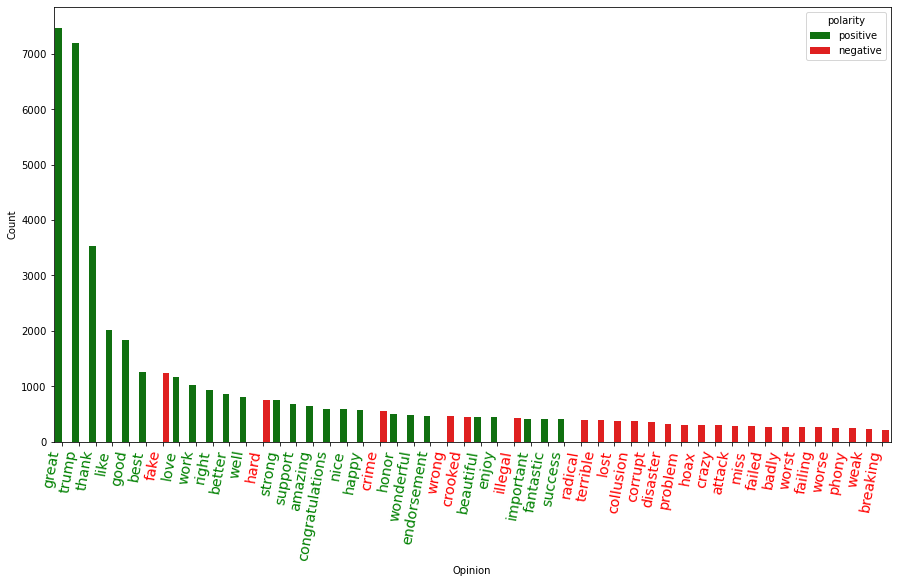

In [24]:
# Call the plot_opinion function to plot The most frequent positive and negative words from the Tweets

plot_opinion(list_top_positives_opinion,list_top_negatives_opinion)

## <span style="color:MidnightBlue"> Insights from the Tweets </span>

Donald Trump's 2016 slogan 'Make America Great Again' became a motto to Trump's supporter but also encaptured the vision for America that lead Donald Trump's strategic decision as President.
It is then not a surprise that 'great' is found as the most used positive words among all tweets. 'good', 'best', 'strong' are also very frequent in Donald Trump's communication.

'fake' news is the most emblematic of Donald Trump's criticism. He made of deconstructing the New York and D.C. establishment his battle in campaign and as President. The words 'failed', 'hoax', 'phony' can have been employed to qualify the Democrats and the Obama years.

We see that Trump often uses the words 'support', 'love', 'amazing', 'congratulations' to engage with his supporters and express his gratitude.


###  <span style="color:Teal"> Step 5: Visualizing contextual words from tweets </span>

In [25]:
# Read The Stop Words File
rdd_stop_words = sc.textFile('stop-words.txt')

In [26]:
# Compute the contextual words RDD by using rdd_tweets_words,
# rdd_positive_words, rdd_negative_words and rdd_stop_words
# neutral words are words that are not positive words or negative words or stop words
contextual_words = rdd_tweets_words.subtract(rdd_positive_words).subtract(rdd_negative_words).subtract(rdd_stop_words)

In [27]:
# Count Each Contextual Word In The Tweets Sorted In Ascending Order Based On Word Frequency
contextual_words_count_ordered = contextual_words.map(lambda word:(word,1))\
                                                    .reduceByKey(lambda a,b: a+b)\
                                                    .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_contextual_words = contextual_words_count_ordered.take(50)  

In [28]:
# the utility function plot_contextual_words plots a bar chart presenting top contextual words
# the parameter are list of tuples containing counts from contextual words

def plot_words(list_contextual_words):
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (25, 25) )
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='RoyalBlue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

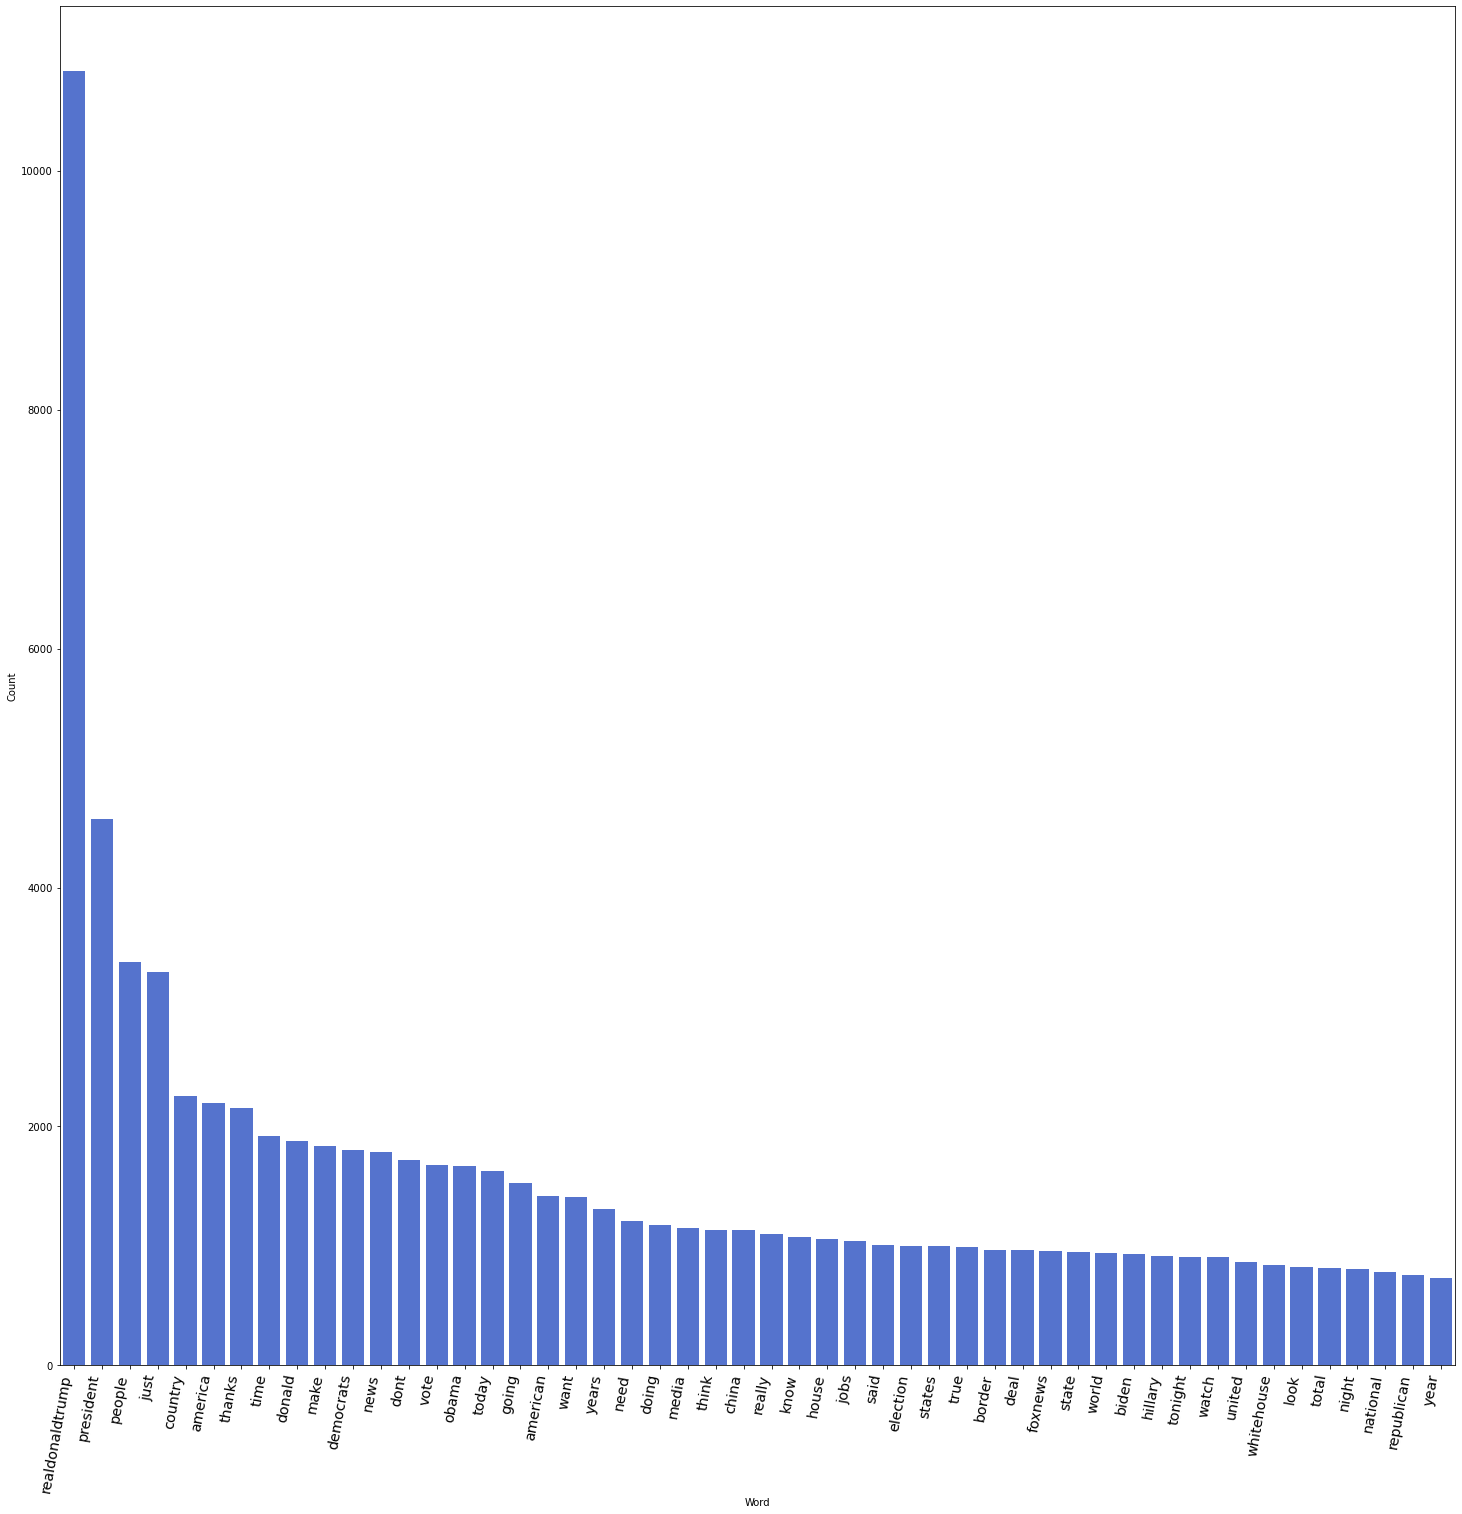

In [29]:
# Plot our tweets top contextual words
plot_words(list_top_contextual_words)

## <span style="color:MidnightBlue"> Insights from the Tweets </span>

The most frequent contextual words revolves around 'America', 'country', 'make'. We see that America was Donald Trump's main concern when running for President and throughout his mandate. His politics was protectionist and he stressed the fact that his strategy was to put America first.

'Obama' appears as the 15th most frequent contextual word. Donald Trump has been vocal about how he disagreed with Obama's politics and often raised criticism to Democrats.


###  <span style="color:Teal"> Step 6: Computing the global sentiment score  </span>

In [30]:
# Compute the global sentiment score: the total count of positive words (e.g. use rdd_positive_words_product_count_kv) minus
# the total count of negative words (e.g. use rdd_negative_words_product_count_kv)


sentiment_score = rdd_positive_words_tweets_count_kv.values().sum()-rdd_negative_words_tweets_count_kv.values().sum()
number_of_words = rdd_tweets_words_kv.values().sum()
print('The sentiment score is : ',sentiment_score, '(out of', number_of_words, 'words)')

The sentiment score is :  25554 (out of 649489 words)


## <span style="color:MidnightBlue"> Insights from the Tweets </span>

The sentiment score is positive which shows that Donald Trump emphasis enthusiasm around him

##  <span style="color:Dodgerblue"> 3- Analyzing Popular Hashtags from Donald Trump Tweets </span>


###  <span style="color:Teal"> Step 1: Extract hashtags from Tweets  </span>

In [31]:
# Split Tweets Using Multiple Separators
def split_with_space_separator(string_value):
    return re.split(' |;|,|"', string_value.strip())

In [32]:
# Extract Hashtags From Tweets
rdd_tweets_hashtags = rdd_tweets.flatMap(split_with_space_separator) \
                                .filter(lambda word: word.startswith('#'))

rdd_tweets_hashtags.take(5)

['#KAG2020', '#MAGA', '#VOTE', '#MAGA🇺🇸🦅rally', '#VOTE']

###  <span style="color:Teal"> Step 2: Cleaning the list of Hashtags  </span>

In [33]:
# Create A Function To Remove Emojis From The Hastags
def remove_emoji(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [34]:
# Create A Function To Remove Punctuation Marks And Special Characters
def remove_special_characters(string_value):
    return re.sub("[^#0-9-a-zA-Z$]+", '', string_value)

In [35]:
# Remove Emojis
# Remove Empty Strings From Hashtags
rdd_tweets_hashtags = rdd_tweets_hashtags.map(remove_emoji).map(remove_special_characters)\
                                            .filter(lambda word: word!="#")
rdd_tweets_hashtags.take(5)

['#KAG2020', '#MAGA', '#VOTE', '#MAGArally', '#VOTE']

In [36]:
# Create An RDD With Key/Value To Count Each Hashtag In The File 
# Use The mapValues Transformation To Assign A Default Count Of 1 For Each Hashtag
# rdd_tweets_hashtags_count_kv_ordered Countains The Number Of Occurences Of Each Hashtag

rdd_tweets_hashtags_count_kv_ordered = rdd_tweets_hashtags.map(lambda tag: (tag, 1)).reduceByKey(lambda a,b: a+b) \
                            .sortBy(lambda tuple: tuple[1], ascending=False)
# Extract Top 25 Hashtags
list_top_hashtags = rdd_tweets_hashtags_count_kv_ordered.take(25)
list_top_hashtags

[('#Trump2016', 695),
 ('#MAGA', 502),
 ('#MakeAmericaGreatAgain', 439),
 ('#CelebApprentice', 289),
 ('#1', 141),
 ('#CelebrityApprentice', 135),
 ('#TimeToGetTough', 95),
 ('#AmericaFirst', 88),
 ('#Trump', 76),
 ('#KAG2020', 72),
 ('#COVID19', 69),
 ('#VoteTrump', 66),
 ('#DrainTheSwamp', 65),
 ('#trumpvlog', 58),
 ('#trump2016', 56),
 ('#USA', 50),
 ('#2A', 49),
 ('#BigLeagueTruth', 49),
 ('#2016', 46),
 ('#TrumpForPresident', 45),
 ('#ImWithYou', 43),
 ('#USMCA', 42),
 ('#DemDebate', 40),
 ('#TrumpTrain', 40),
 ('#CrookedHillary', 38)]

###  <span style="color:Teal"> Step 3: Vizualising The Most Popular Hastags  </span>

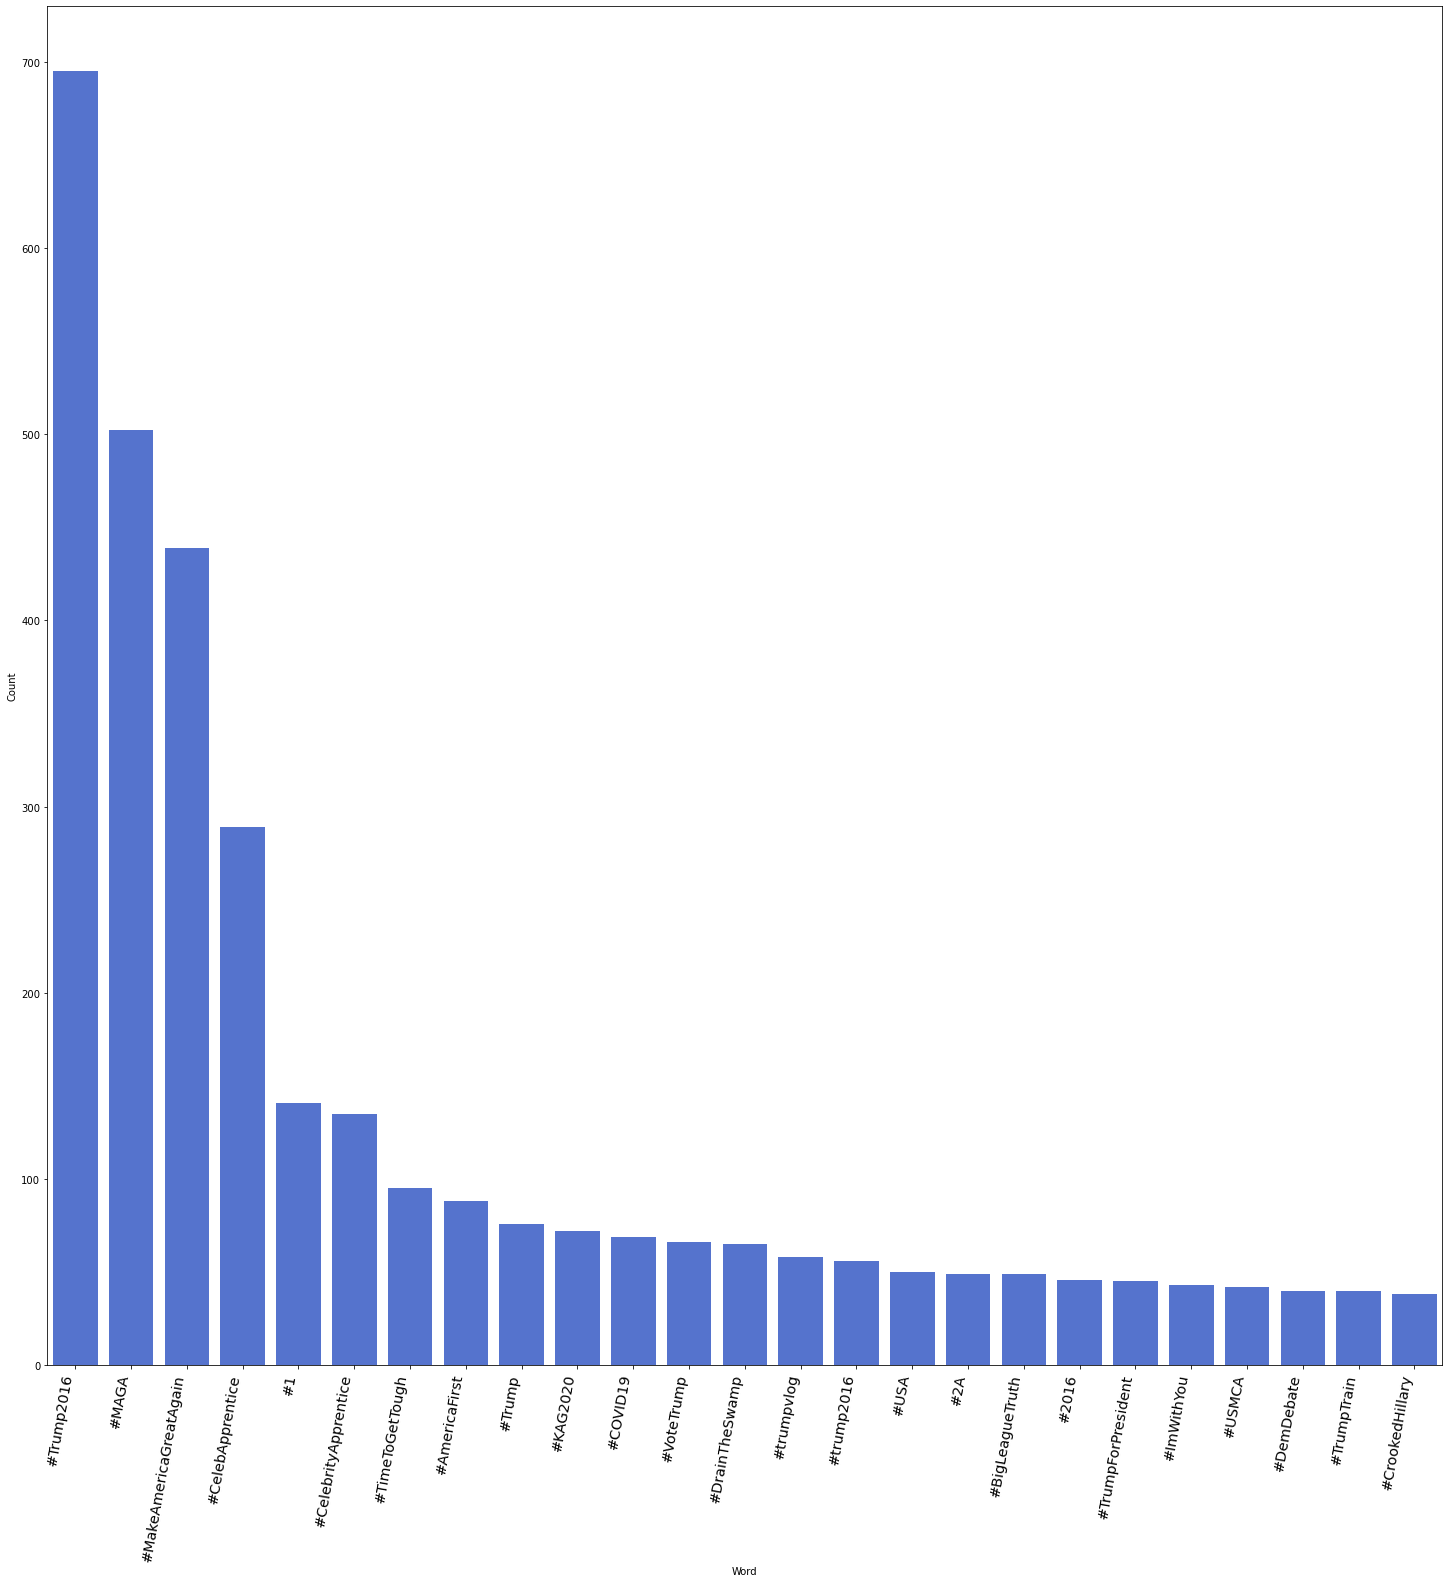

In [37]:
# Call the plot_words function defined previously to plot our top hashtags
plot_words(list_top_hashtags)

## <span style="color:MidnightBlue"> Insights from the Tweets </span>

The most frequent hashtags in Donald Trump are his campaign slogans #Trump2016, #MAGA, #MakeAmericaGreatAgain.
Not only did his slogans became popular in the rise to power, but Trump kept using these hashtags in office.

Since the 1990s Donald Trump was well-known for his TV show 'The Apprentice' where he could hire candidates that would work for his business. The #CelebApprentice and #CelebrityApprentice hashtags refers to this period.

##  <span style="color:Dodgerblue"> 3- Analyzing Tweets Over Time </span>

###  <span style="color:Teal"> Step 1: Create DataFrame of Tweets  </span>

In [38]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("Donald Trump Twitter").getOrCreate()
from pyspark.sql.types import *

tweetSchema = StructType ( [StructField("tweet", StringType(), False),
                              StructField("time", TimestampType(), False)] )

tweet_df = spark.read.csv('trump_tweets.txt', schema=tweetSchema, header=True, sep=';',timestampFormat='dd/MM/yyyy HH:mm:ss')

tweet_df.show(5)

+--------------------+-------------------+
|               tweet|               time|
+--------------------+-------------------+
|I was thrilled to...|2020-03-03 01:34:50|
|RT @CBS_Herridge:...|2020-01-17 03:22:47|
|The Unsolicited M...|2020-09-12 20:10:58|
|RT @MZHemingway: ...|2020-01-17 13:13:59|
|RT @WhiteHouse: P...|2020-01-17 00:11:56|
+--------------------+-------------------+
only showing top 5 rows



###  <span style="color:Teal"> Step 2: Cleaning the DataFrame of Tweets  </span>

In [39]:
# Remove Rows That Are Only URLs
# Remove Rows With NULL Values
tweet_df1=tweet_df.filter(tweet_df["tweet"].rlike('^(?!https).+')).na.drop()
tweet_df1.show(5)

+--------------------+-------------------+
|               tweet|               time|
+--------------------+-------------------+
|I was thrilled to...|2020-03-03 01:34:50|
|RT @CBS_Herridge:...|2020-01-17 03:22:47|
|The Unsolicited M...|2020-09-12 20:10:58|
|RT @MZHemingway: ...|2020-01-17 13:13:59|
|RT @WhiteHouse: P...|2020-01-17 00:11:56|
+--------------------+-------------------+
only showing top 5 rows



In [40]:
# Extract Month From TimeStamp
from pyspark.sql import functions as F
tweet_df2 = tweet_df1.withColumn('month', F.from_unixtime(F.unix_timestamp(tweet_df1['time'], 'dd/MM/yyyy HH:mm:ss'), 'MM/yyyy'))
tweet_df2.show(5)

+--------------------+-------------------+-------+
|               tweet|               time|  month|
+--------------------+-------------------+-------+
|I was thrilled to...|2020-03-03 01:34:50|03/2020|
|RT @CBS_Herridge:...|2020-01-17 03:22:47|01/2020|
|The Unsolicited M...|2020-09-12 20:10:58|09/2020|
|RT @MZHemingway: ...|2020-01-17 13:13:59|01/2020|
|RT @WhiteHouse: P...|2020-01-17 00:11:56|01/2020|
+--------------------+-------------------+-------+
only showing top 5 rows



In [41]:
# Count Tweets Data Between Original Tweets and Retweets
original_tweets=tweet_df1.filter(tweet_df["tweet"].rlike('^(?!RT).+')).na.drop()

retweets=tweet_df1.filter(tweet_df["tweet"].rlike('^RT.+')).na.drop()

print('There are {0} Tweets and {1} Retweets'.format(original_tweets.count(),retweets.count()))

There are 46250 Tweets and 7774 Retweets


In [42]:
def plot_dates(list_dates):
    
    pd_df = pd.DataFrame({
        'Date':  [ t[0] for t in list_dates ],
        'Count': [ t[1] for t in list_dates ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (30,15) )
    
    chart=sb.barplot(data=pd_df, x='Date', y='Count', order=pd_df['Date'], color='SlateBlue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

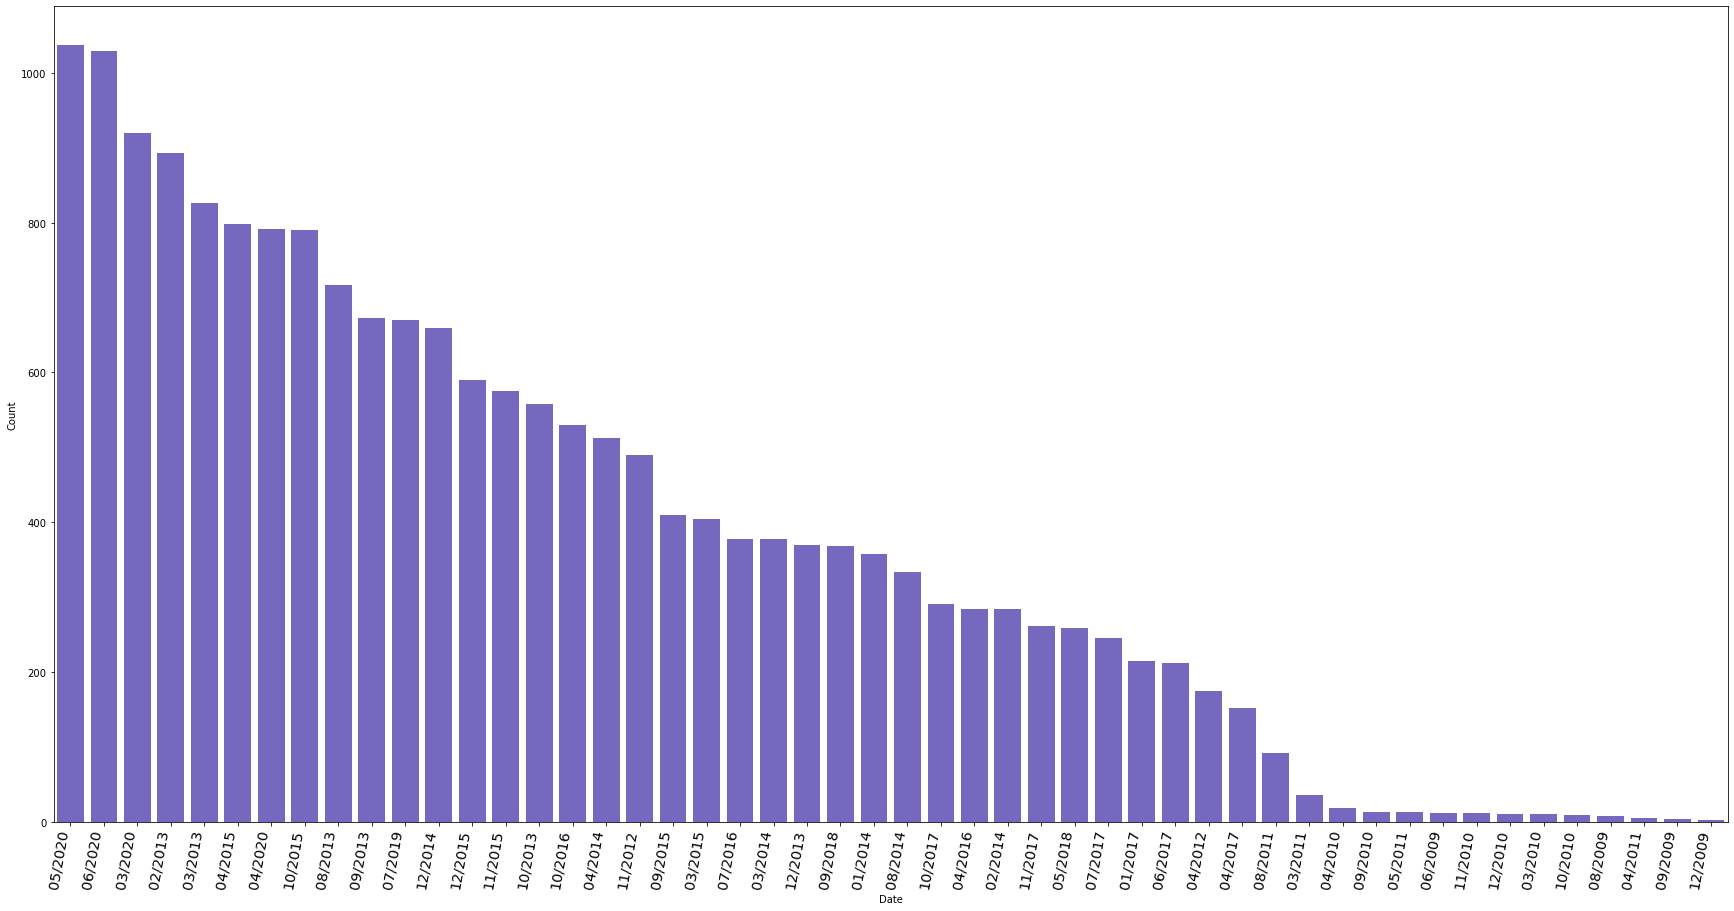

In [43]:
# Plot the Top 50 Months By Frequency Of Tweets
list_dates = tweet_df2.groupBy("month").count().rdd.take(50)
plot_dates(list_dates)

## <span style="color:MidnightBlue"> Insights from the Tweets </span>

May, June and March 2020 were the months where Donald Trump tweeted or was retweeted the most. Indeed in the Covid-pandemic, the President relied on Twitter more than ever to communicate with his supporters and also because he was running for office for the 2020 elections which happened mostly virtually due to the pandemic.

More surprising is February 2013 popping up as the 4th more active month. Back then Donald Trump raised many critism towards the Obama administration. Donald Trump was encouraged by a user to run for Presidency since he was so critical, to which Donald Trump replied ironically 'Be careful!' on February 7, 2013. One can wonder whether Donald Trump had already planned to run for office back then or not. But one thing is sure very few people had anticipated that he would actually win when he declared his candidacy back in 2015.